# Train/Val/Test

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split

In [3]:
def show_top_genres(df, name_sample):
    class_counts = df['genre'].value_counts()
    top_n = 20  
    top_classes = class_counts.head(top_n)
    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_classes.values, y=top_classes.index, palette="viridis")
    plt.title(f"{name_sample} Top Genres by Number of Samples")
    plt.xlabel("Number of Samples")
    plt.ylabel("Genre")
    plt.tight_layout()
    plt.show()

def show_top_genres_singly(df, name_sample):
    all_genres = []

    for genre_string in df['genre']:
        genres = [g.strip() for g in genre_string.split(',') if g.strip()]
        all_genres.extend(genres)
        
    genre_counts = Counter(all_genres)
    genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['genre', 'count'])
    genre_counts_df = genre_counts_df.sort_values(by='count', ascending=False).reset_index(drop=True)

    top_n = 20  
    top_classes = genre_counts_df.head(top_n)
    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_classes['count'], y=top_classes['genre'], palette="viridis")
    plt.title(f"{name_sample} Top Genres (singly) by Number of Samples")
    plt.xlabel("Number of Samples")
    plt.ylabel("Genre")
    plt.tight_layout()
    plt.show()

In [4]:
def split_multilingual_dataset(df_path, output_postfix=None, input_format='csv', random_state=42):
    """
    Делит датасет на:
    - train (рус + англ, 80%)
    - val/test (по 10% отдельно для рус и англ, + объединённые версии)

    Аргументы:
        df_path: str — путь до данных
        output_postfix: str — постфикс для сохранения разбиений
        input_format: str — 'csv' или 'parquet'
        random_state: int — для воспроизводимости

    Возвращает:
        dict из 7 датафреймов: train, val_ru, val_en, val_mix, test_ru, test_en, test_mix
    """

    # Загрузка данных
    if input_format == 'csv':
        df = pd.read_csv(df_path)
    elif input_format == 'parquet':
        df = pd.read_parquet(df_path)
    else:
        raise ValueError("input_format должен быть 'csv' или 'parquet'")

    # Делим по языку
    df_ru = df[df['language'] == 'russian'].reset_index(drop=True)
    df_en = df[df['language'] == 'english'].reset_index(drop=True)

    # Вспомогательные функции для фильтрации редких жанров
    # Перед первым split нужен минимум 3 экземпляра жанра (1 train, 1 val, 1 test)
    def filter_low_freq(df, label_col='genre', min_count=3):
        counts = df[label_col].value_counts()
        allowed = counts[counts >= min_count].index
        return df[df[label_col].isin(allowed)].reset_index(drop=True)

    # После первого split — минимум 2 экземпляра (для split 50/50)
    def filter_low_freq_2(df, label_col='genre', min_count=2):
        counts = df[label_col].value_counts()
        allowed = counts[counts >= min_count].index
        return df[df[label_col].isin(allowed)].reset_index(drop=True)

    # Перед первым split: фильтруем жанры с >=3 экземплярамиа
    df_ru_for_split = filter_low_freq(df_ru, min_count=3)
    df_en_for_split = filter_low_freq(df_en, min_count=3)

    # Сохраняем редкие строки для возврата в train (1 или 2 экземпляра жанра)
    ru_singleton_1 = df_ru[~df_ru.index.isin(df_ru_for_split.index)]
    en_singleton_1 = df_en[~df_en.index.isin(df_en_for_split.index)]

    # Первый split: train (80%) и valtest (20%), стратифицировано по жанру
    ru_valtest, ru_train = train_test_split(
        df_ru_for_split, test_size=0.8,
        stratify=df_ru_for_split['genre'], random_state=random_state
    )
    en_valtest, en_train = train_test_split(
        df_en_for_split, test_size=0.8,
        stratify=df_en_for_split['genre'], random_state=random_state
    )

    # После первого split: удаляем из valtest жанры с единственным экземпляром
    ru_valtest_for_split = filter_low_freq_2(ru_valtest, min_count=2)
    en_valtest_for_split = filter_low_freq_2(en_valtest, min_count=2)

    # Сохраняем снова редкие строки для возврата в train (жанры, у которых в valtest 1 экземпляр)
    ru_singleton_2 = ru_valtest[~ru_valtest.index.isin(ru_valtest_for_split.index)]
    en_singleton_2 = en_valtest[~en_valtest.index.isin(en_valtest_for_split.index)]

    # Второй split: val (50%) и test (50%), стратифицировано по жанру
    ru_val, ru_test = train_test_split(
        ru_valtest_for_split, test_size=0.5,
        stratify=ru_valtest_for_split['genre'], random_state=random_state
    )
    en_val, en_test = train_test_split(
        en_valtest_for_split, test_size=0.5,
        stratify=en_valtest_for_split['genre'], random_state=random_state
    )

    # Формируем финальные выборки
    # Все строки с редкими жанрами (которые не попали в стратифицированный split) возвращаются только в train
    train = pd.concat([
        ru_train, en_train,
        ru_singleton_1, en_singleton_1,
        ru_singleton_2, en_singleton_2
    ]).reset_index(drop=True)

    val_ru = ru_val.reset_index(drop=True)
    val_en = en_val.reset_index(drop=True)
    val_mix = pd.concat([val_ru, val_en]).reset_index(drop=True)
    test_ru = ru_test.reset_index(drop=True)
    test_en = en_test.reset_index(drop=True)
    test_mix = pd.concat([test_ru, test_en]).reset_index(drop=True)

    splits = {
        'train': train,
        'val_ru': val_ru,
        'val_en': val_en,
        'val_mix': val_mix,
        'test_ru': test_ru,
        'test_en': test_en,
        'test_mix': test_mix
    }

    # Сохраняем csv, если указан постфикс
    if output_postfix:
        for name, df_part in splits.items():
            filename = f'{name}_{output_postfix}.csv'
            df_part.to_csv(filename, index=False)

    return splits

## Top_genres_downsampled

In [ ]:
splits = split_multilingual_dataset('data/top_genres_downsampled.csv', output_postfix='top_down')

C:\Users\Ogurchikov\AppData\Local\Temp\ipykernel_16188\3457793714.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_classes['count'], y=top_classes['genre'], palette="viridis")


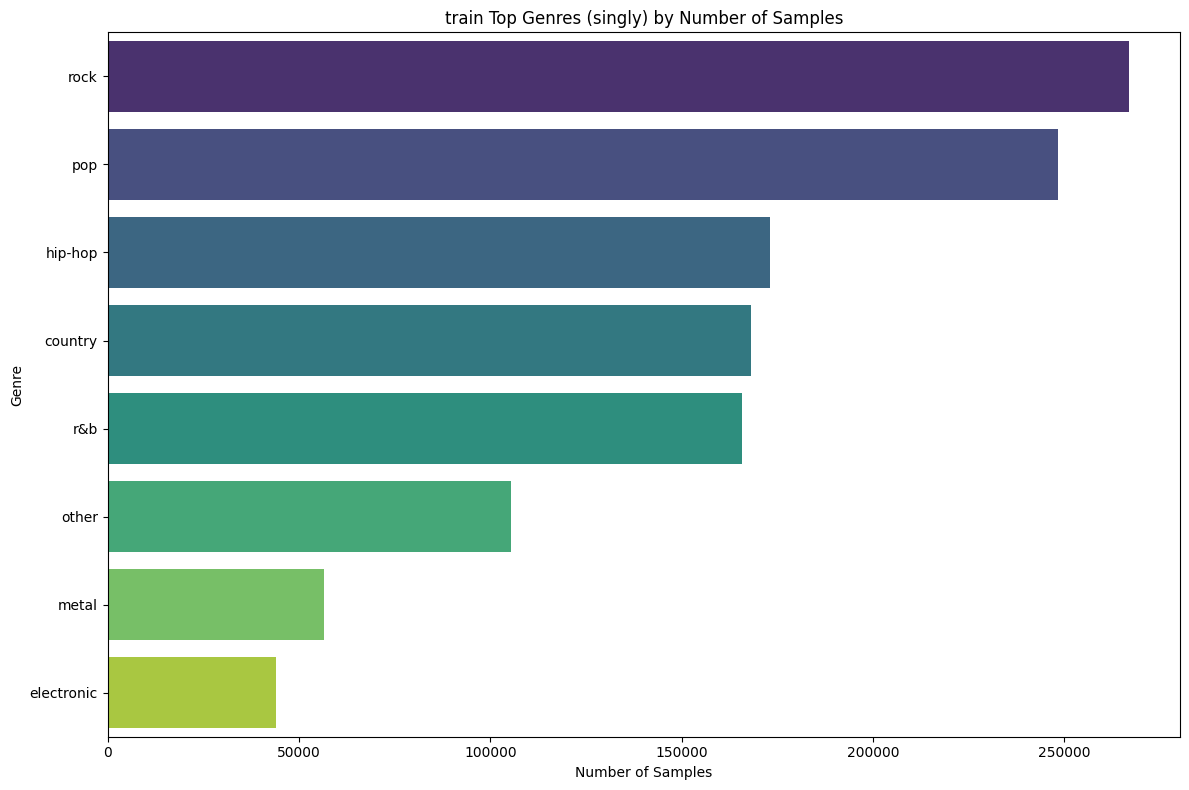

C:\Users\Ogurchikov\AppData\Local\Temp\ipykernel_16188\3457793714.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_classes['count'], y=top_classes['genre'], palette="viridis")


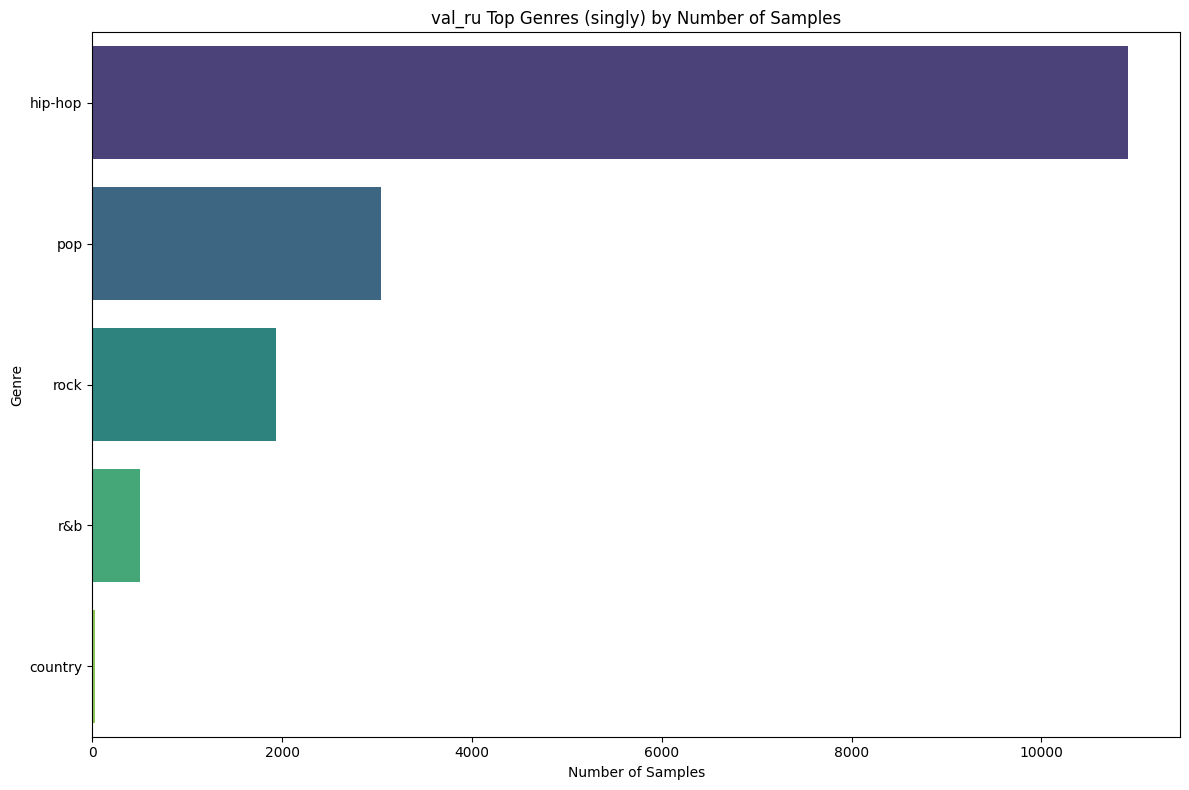

C:\Users\Ogurchikov\AppData\Local\Temp\ipykernel_16188\3457793714.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_classes['count'], y=top_classes['genre'], palette="viridis")


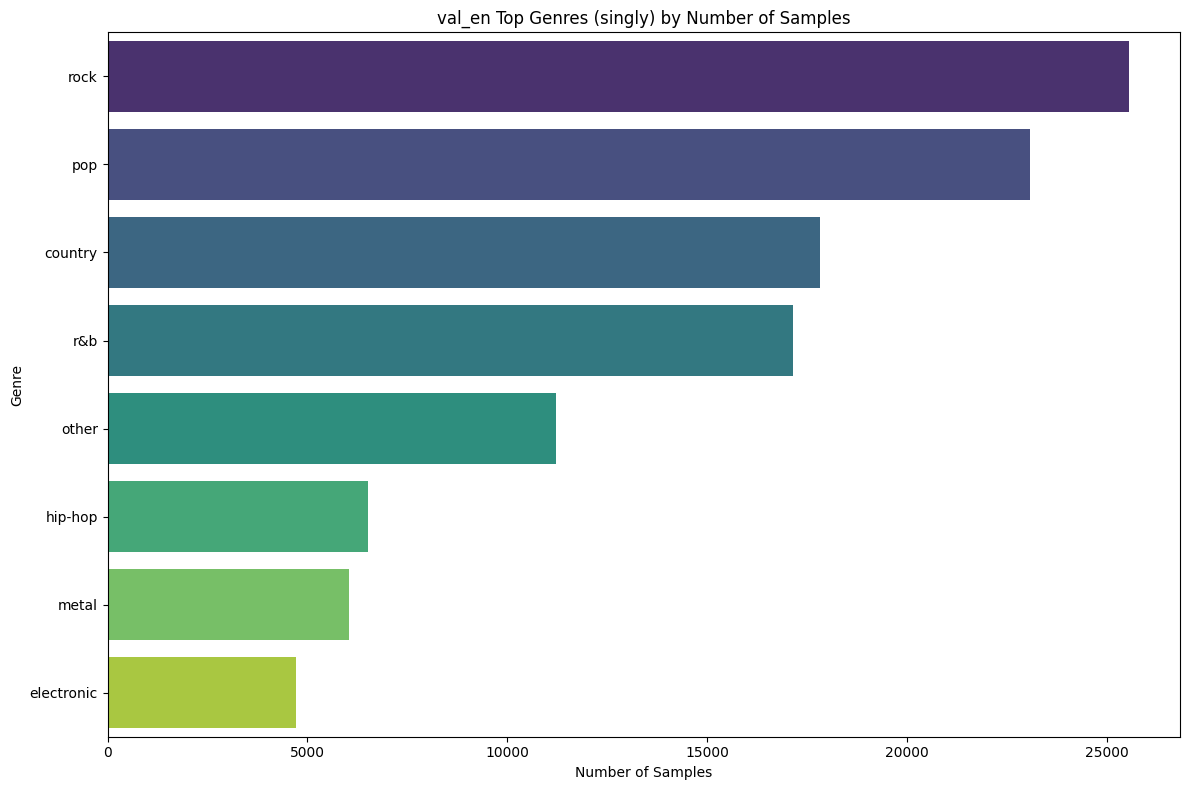

C:\Users\Ogurchikov\AppData\Local\Temp\ipykernel_16188\3457793714.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_classes['count'], y=top_classes['genre'], palette="viridis")


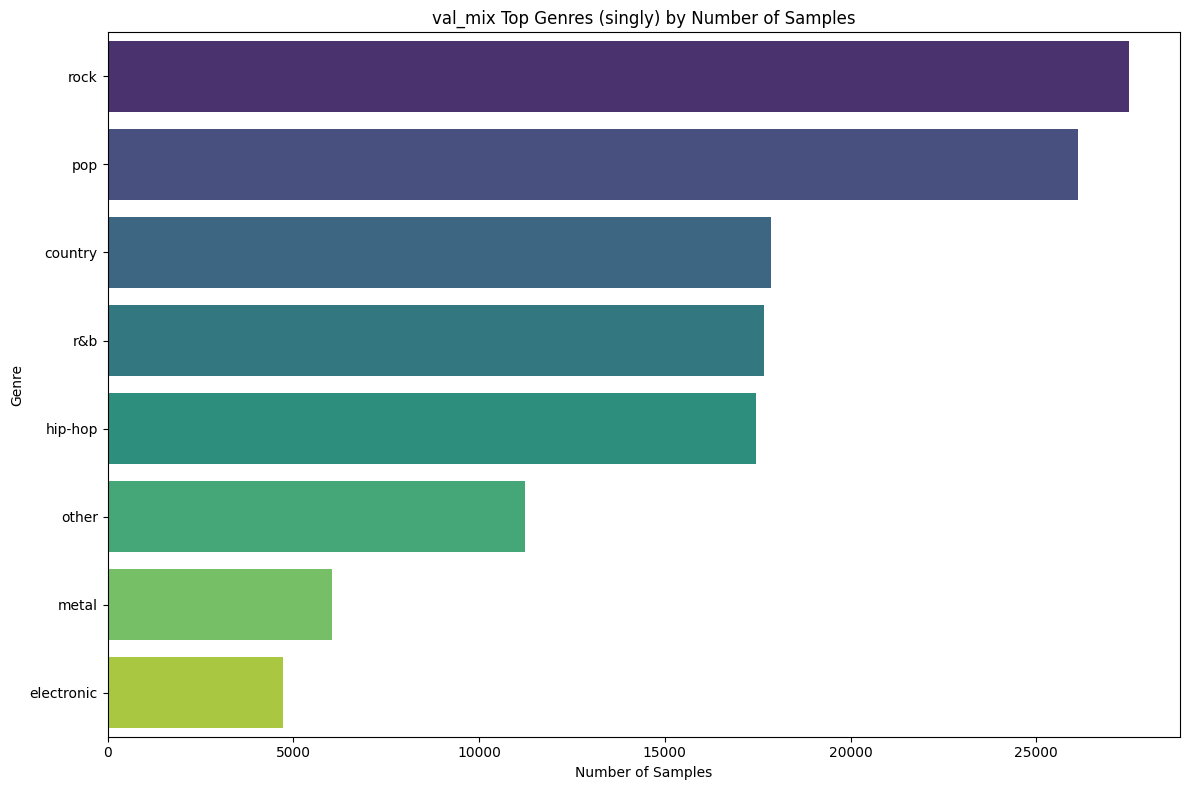

C:\Users\Ogurchikov\AppData\Local\Temp\ipykernel_16188\3457793714.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_classes['count'], y=top_classes['genre'], palette="viridis")


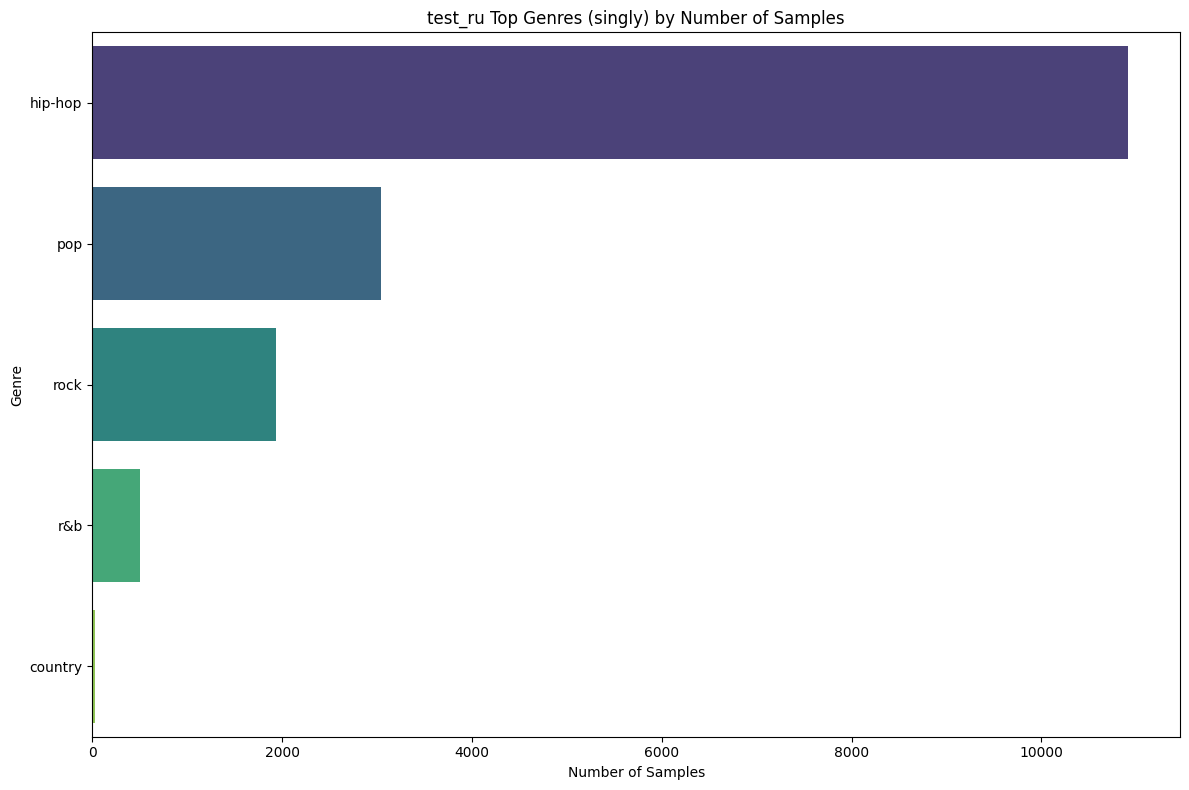

C:\Users\Ogurchikov\AppData\Local\Temp\ipykernel_16188\3457793714.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_classes['count'], y=top_classes['genre'], palette="viridis")


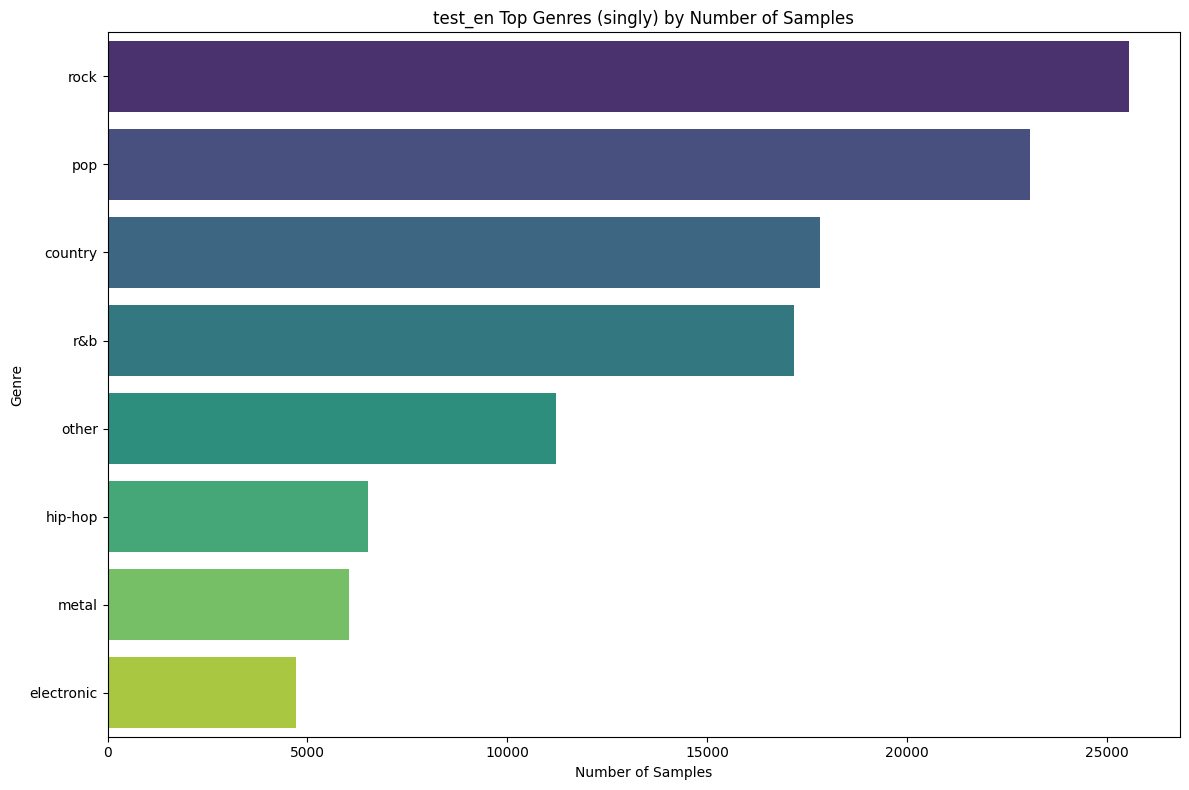

C:\Users\Ogurchikov\AppData\Local\Temp\ipykernel_16188\3457793714.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_classes['count'], y=top_classes['genre'], palette="viridis")


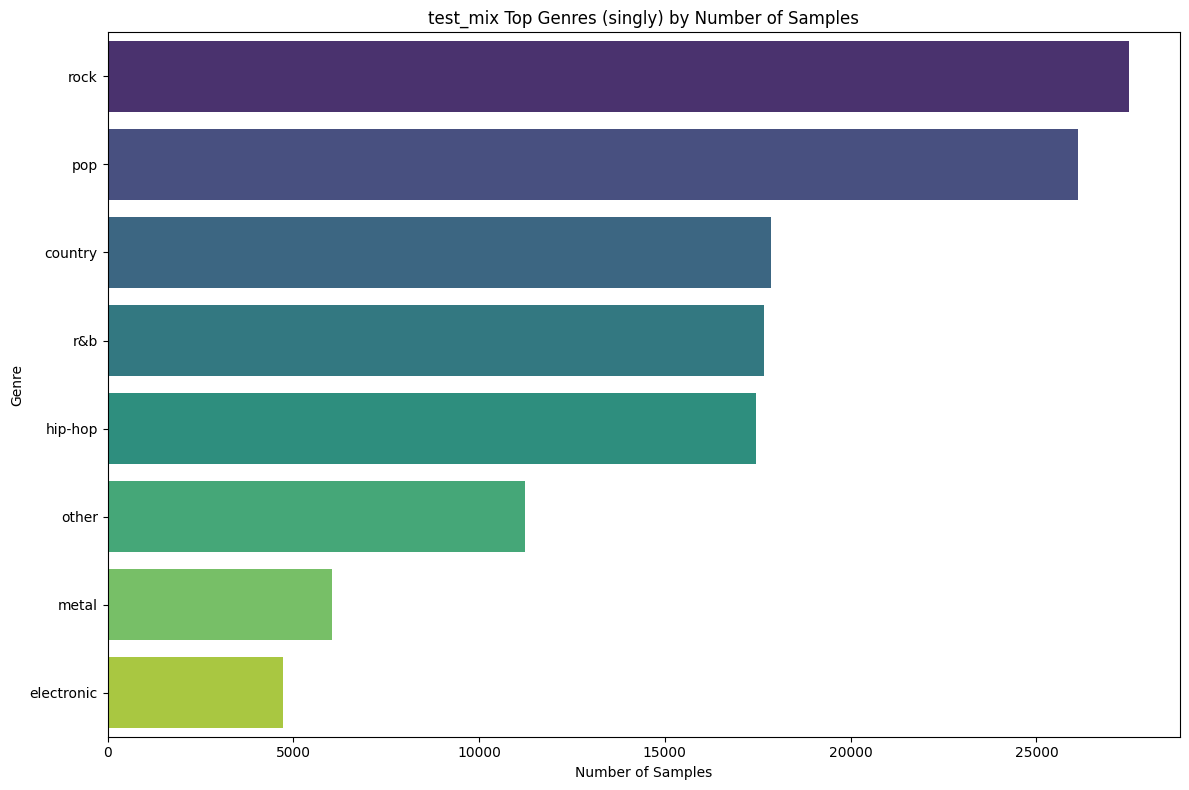

In [27]:
# Наглядная работа
for sample in ['train','val_ru','val_en','val_mix','test_ru','test_en','test_mix']:    
    show_top_genres_singly(splits[sample], sample)

## Top_genres

In [ ]:
splits = split_multilingual_dataset('data/top_genres.csv', output_postfix='top')

## All_genres_downsampled

In [ ]:
splits = split_multilingual_dataset('data/all_genres_downsampled.csv', output_postfix='all_down')

## All_genres

In [ ]:
splits = split_multilingual_dataset('data/all_genres.csv', output_postfix='all')